In [16]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

%matplotlib notebook
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
import Common_Functions as cf
import time
import mplcursors

from matplotlib.backends.backend_agg import FigureCanvasAgg 
plt.get_backend()


test_size = 0.2
valid_size = 0.2
N = 21


n_estimators = 100
max_depth = 3
learning_rate = 0.1
min_child_weight = 1
subsample = 1
colsample_bytree = 1
colsample_bylevel = 1
gamma = 0
model_seed = 100


style.use('seaborn-darkgrid')

In [17]:
AAPL_df = pd.read_csv('AAPL.csv', parse_dates = True, index_col = 0)
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317


In [18]:
AAPL_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5121 entries, 0 to 5120
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       5121 non-null   object 
 1   HIGH       5121 non-null   float64
 2   LOW        5121 non-null   float64
 3   OPEN       5121 non-null   float64
 4   CLOSE      5121 non-null   float64
 5   VOLUME     5121 non-null   float64
 6   ADJ_CLOSE  5121 non-null   float64
dtypes: float64(6), object(1)
memory usage: 320.1+ KB


In [19]:
AAPL_df.loc[:, 'DATE'] = pd.to_datetime(AAPL_df['DATE'], format = '%Y-%m-%d')

In [20]:
AAPL_df.dtypes

DATE         datetime64[ns]
HIGH                float64
LOW                 float64
OPEN                float64
CLOSE               float64
VOLUME              float64
ADJ_CLOSE           float64
dtype: object

<IPython.core.display.Javascript object>


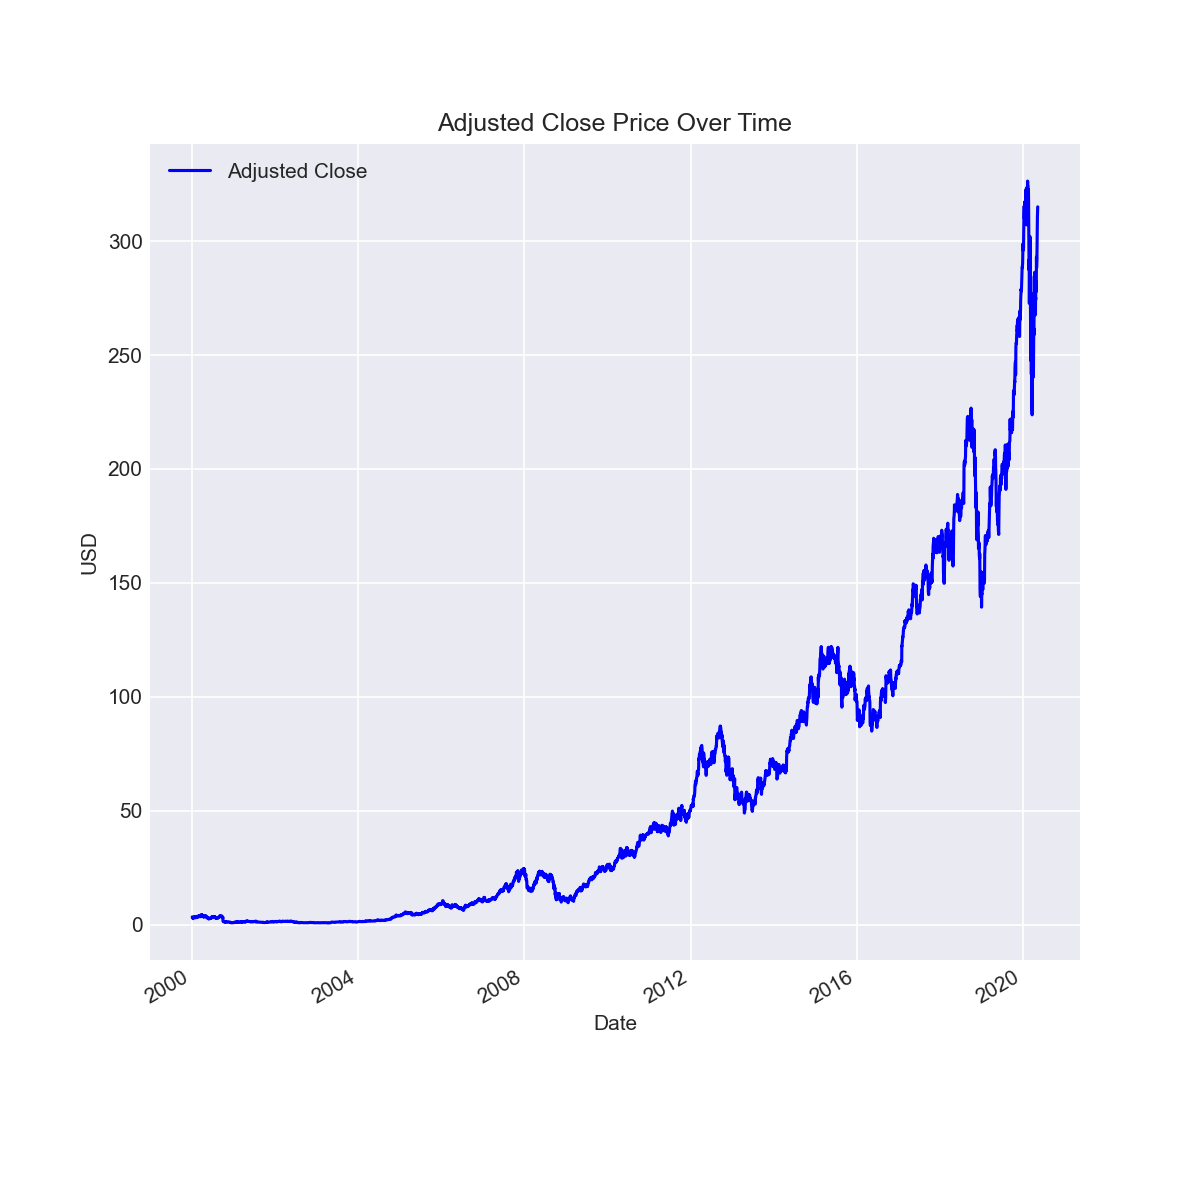

In [23]:
rcParams['figure.figsize'] = 8, 8

ax = AAPL_df.plot(x = 'DATE', y = 'ADJ_CLOSE', style = 'b-', grid = True)
ax.set_ylabel('USD')
ax.set_xlabel('Date')
ax.legend(['Adjusted Close'], loc = 'upper left')
ax.set_title('Adjusted Close Price Over Time')

plt.show();

<IPython.core.display.Javascript object>


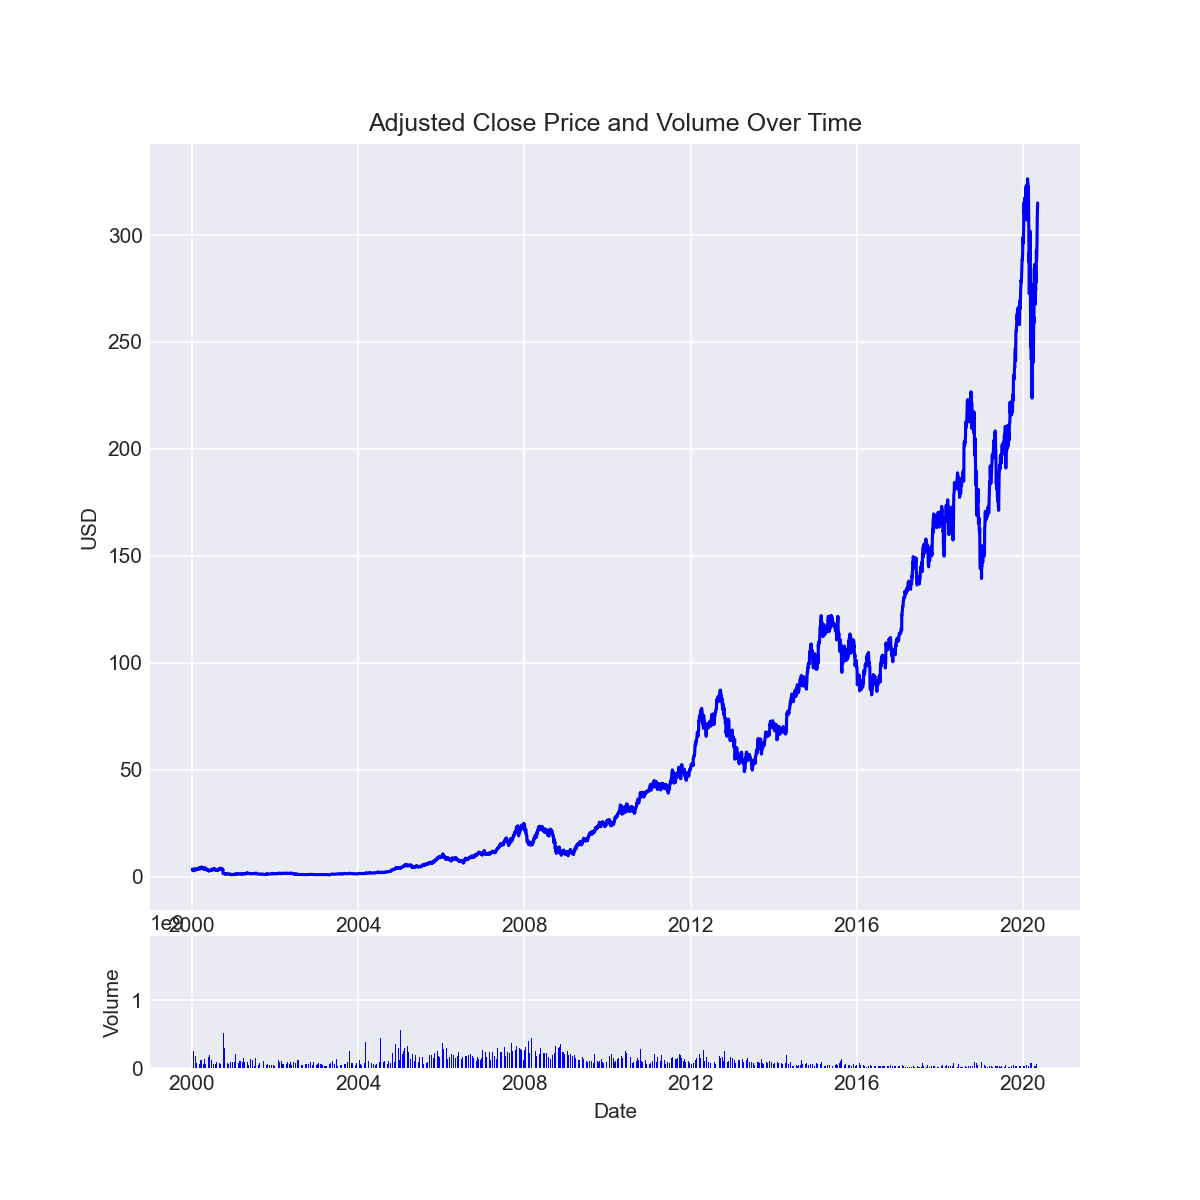

In [22]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

ax1 = plt.subplot2grid((6,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan = 1, colspan = 1, sharex = ax1)

ax1.plot(AAPL_df['DATE'], AAPL_df['ADJ_CLOSE'], 'b-')
ax1.set_ylabel('USD')
ax1.set_title('Adjusted Close Price and Volume Over Time', fontweight = 'bold')
ax1.grid(True)

ax2.bar(AAPL_df['DATE'], AAPL_df['VOLUME'], color = 'blue')
ax2.grid(True)
ax2.set_ylabel('Volume')

plt.xlabel('Date')

plt.show();

In [24]:
AAPL_df['RANGE_HL'] = AAPL_df['HIGH'] - AAPL_df['LOW']
AAPL_df['RANGE_OC'] = AAPL_df['OPEN'] - AAPL_df['CLOSE']
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,RANGE_HL,RANGE_OC
0,2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857,0.386161,-0.252232
1,2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071,0.337054,0.205357
2,2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448,0.270089,-0.008929
3,2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188,0.428571,0.397321
4,2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317,0.196429,-0.107143


In [26]:
AAPL_df['ORDER'] = [idx for idx in list(range(len(AAPL_df)))]

merging_keys = ['ORDER']

lag_cols = ['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']
lag_cols

['OPEN', 'CLOSE', 'VOLUME', 'RANGE_HL', 'RANGE_OC']

In [28]:
days_lagging = [day+1 for day in range(N)]

for lag in tqdm_notebook(days_lagging):
    train_lag = AAPL_df[merging_keys + lag_cols].copy()
    
    train_lag['ORDER'] = train_lag['ORDER'] + lag
    
    foo = lambda num: '{}_LAG_{}'.format(num, lag) if num in lag_cols else num
    train_lag = train_lag.rename(columns = foo)
    
    AAPL_df = pd.merge(AAPL_df, train_lag, on = merging_keys, how = 'left')
    
del train_lag

AAPL_df = AAPL_df[N:]

AAPL_df.head()

<ipython-input-28-f104418b274b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lag in tqdm_notebook(days_lagging):


,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,RANGE_HL,RANGE_OC,ORDER,...,OPEN_LAG_20,CLOSE_LAG_20,VOLUME_LAG_20,RANGE_HL_LAG_20,RANGE_OC_LAG_20,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21
21,2000-02-02,3.647321,3.464286,3.598214,3.529018,116048800.0,3.055062,0.183036,0.069196,21,...,3.866071,3.660714,128094400.0,0.337054,0.205357,3.745536,3.997768,133949200.0,0.386161,-0.252232
22,2000-02-03,3.723214,3.580357,3.582589,3.689732,118798400.0,3.194192,0.142857,-0.107143,22,...,3.705357,3.714286,194580400.0,0.270089,-0.008929,3.866071,3.660714,128094400.0,0.337054,0.205357
23,2000-02-04,3.928571,3.700893,3.712054,3.857143,106330000.0,3.339118,0.227679,-0.145089,23,...,3.790179,3.392857,191993200.0,0.428571,0.397321,3.705357,3.714286,194580400.0,0.270089,-0.008929
24,2000-02-07,4.080357,3.783482,3.857143,4.073661,110266800.0,3.526558,0.296875,-0.216518,24,...,3.446429,3.553571,115183600.0,0.196429,-0.107143,3.790179,3.392857,191993200.0,0.428571,0.397321
25,2000-02-08,4.147321,3.973214,4.071429,4.102679,102160800.0,3.551679,0.174107,-0.031250,25,...,3.642857,3.491071,126266000.0,0.267857,0.151786,3.446429,3.553571,115183600.0,0.196429,-0.107143


In [30]:
for col in lag_cols:
    AAPL_df = cf.get_mov_avg_std(AAPL_df, col)
    
AAPL_df = cf.get_mov_avg_std(AAPL_df, 'ADJ_CLOSE')
    
AAPL_df.head()

,DATE,HIGH,LOW,OPEN,CLOSE,VOLUME,ADJ_CLOSE,RANGE_HL,RANGE_OC,ORDER,...,CLOSE_MEAN,CLOSE_STD,VOLUME_MEAN,VOLUME_STD,RANGE_HL_MEAN,RANGE_HL_STD,RANGE_OC_MEAN,RANGE_OC_STD,ADJ_CLOSE_MEAN,ADJ_CLOSE_STD
21,2000-02-02,3.647321,3.464286,3.598214,3.529018,116048800.0,3.055062,0.183036,0.069196,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2000-02-03,3.723214,3.580357,3.582589,3.689732,118798400.0,3.194192,0.142857,-0.107143,22,...,3.529018,NaN,1.160488e+08,NaN,0.183036,NaN,0.069196,NaN,3.055062,NaN
23,2000-02-04,3.928571,3.700893,3.712054,3.857143,106330000.0,3.339118,0.227679,-0.145089,23,...,3.609375,0.113642,1.174236e+08,1.944261e+06,0.162947,0.028411,-0.018973,0.124691,3.124627,0.098380
24,2000-02-07,4.080357,3.783482,3.857143,4.073661,110266800.0,3.526558,0.296875,-0.216518,24,...,3.691964,0.164074,1.137257e+08,6.550781e+06,0.184524,0.042430,-0.061012,0.114349,3.196124,0.142038
25,2000-02-08,4.147321,3.973214,4.071429,4.102679,102160800.0,3.551679,0.174107,-0.031250,25,...,3.787388,0.233174,1.128610e+08,5.621347e+06,0.212612,0.065999,-0.099888,0.121502,3.278733,0.201857


In [32]:
valid_len = int(valid_size * len(AAPL_df))
test_len = int(test_size * len(AAPL_df))
train_len = len(AAPL_df) - (valid_len + test_len)
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))
print('Valid Set Len: ' + str(valid_len))

train = AAPL_df[:train_len]
valid = AAPL_df[train_len:(train_len + valid_len)]
test = AAPL_df[(train_len + valid_len):]
print('Train Set Shape: ' + str(train.shape))
print('Valid Set Shape: ' + str(valid.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 3060
Test Set Len: 1020
Valid Set Len: 1020
Train Set Shape: (3060, 127)
Valid Set Shape: (1020, 127)
Test Set Shape: (1020, 127)


In [34]:
scaling_cols = ['ADJ_CLOSE']

for num in range(1, N+1):
    scaling_cols.append('OPEN_LAG_'+str(num))
    scaling_cols.append('CLOSE_LAG_'+str(num))
    scaling_cols.append('VOLUME_LAG_'+str(num))
    scaling_cols.append('RANGE_HL_LAG_'+str(num))
    scaling_cols.append('RANGE_OC_LAG_'+str(num))
    
scaler = StandardScaler()
train_scale = scaler.fit_transform(train[scaling_cols])
train_df_scaled = pd.DataFrame(train_scale, columns = scaling_cols)
train_df_scaled[['DATE']] = train.reset_index()[['DATE']]
train_df_scaled.head()

,ADJ_CLOSE,OPEN_LAG_1,CLOSE_LAG_1,VOLUME_LAG_1,RANGE_HL_LAG_1,RANGE_OC_LAG_1,OPEN_LAG_2,CLOSE_LAG_2,VOLUME_LAG_2,RANGE_HL_LAG_2,...,CLOSE_LAG_20,VOLUME_LAG_20,RANGE_HL_LAG_20,RANGE_OC_LAG_20,OPEN_LAG_21,CLOSE_LAG_21,VOLUME_LAG_21,RANGE_HL_LAG_21,RANGE_OC_LAG_21,DATE
0,-0.697623,-0.687719,-0.694920,-0.678118,-0.489191,0.361625,-0.694056,-0.688077,0.224639,-0.161736,...,-0.693595,-0.219284,-0.142721,0.566715,-0.688930,-0.673640,-0.164297,-0.036517,-0.719077,2000-02-02
1,-0.688541,-0.694296,-0.697828,-0.334160,-0.479852,0.183943,-0.687969,-0.695177,-0.678185,-0.488803,...,-0.690418,0.406086,-0.287330,-0.035482,-0.681765,-0.693672,-0.219369,-0.142567,0.566789,2000-02-03
2,-0.679082,-0.695182,-0.688724,-0.308278,-0.563904,-0.300090,-0.694563,-0.698092,-0.334229,-0.479458,...,-0.709480,0.381751,0.054911,1.106184,-0.691318,-0.690488,0.406015,-0.287181,-0.035372,2000-02-04
3,-0.666847,-0.687845,-0.679241,-0.425645,-0.386460,-0.404250,-0.695451,-0.688965,-0.308347,-0.563561,...,-0.699949,-0.340724,-0.446400,-0.311490,-0.686276,-0.709592,0.381680,0.055071,1.106226,2000-02-07
4,-0.665207,-0.679623,-0.666976,-0.388587,-0.241704,-0.600314,-0.688095,-0.679457,-0.425714,-0.386010,...,-0.703655,-0.236482,-0.292151,0.416165,-0.706709,-0.700040,-0.340811,-0.446256,-0.311363,2000-02-08


In [35]:
valid_df_scaled = valid[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = valid.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    valid_df_scaled = pd.concat([valid_df_scaled, temp], axis = 1)

temp2 = valid.apply(lambda row: cf.scale_row(row['ADJ_CLOSE'], row['ADJ_CLOSE_MEAN'], row['ADJ_CLOSE_STD']), axis = 1)
valid_df_scaled['ADJ_CLOSE'] = temp2
    
valid_df_scaled.head()

<ipython-input-35-0146b68dc5e2>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,OPEN_LAG_1,OPEN_LAG_2,OPEN_LAG_3,OPEN_LAG_4,OPEN_LAG_5,OPEN_LAG_6,OPEN_LAG_7,OPEN_LAG_8,OPEN_LAG_9,...,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21,ADJ_CLOSE
3081,2012-04-02,-0.058733,0.515684,1.317853,-0.429733,-1.345070,-1.244800,-1.632998,-0.922501,-1.385180,...,-1.507798,-1.374981,-0.342580,-0.060523,-0.928611,0.907528,-0.832766,1.749606,-0.057780,1.275940
3082,2012-04-03,-1.226808,-0.129357,0.504768,1.390318,-0.538921,-1.549402,-1.438709,-1.867258,-1.082908,...,1.618001,-0.891909,-0.796732,-0.056907,0.145217,-0.476861,0.838928,-0.408178,1.442366,2.226509
3083,2012-04-04,1.397051,-1.241060,-0.522238,-0.106891,0.473138,-0.790499,-1.452357,-1.379854,-1.660551,...,0.034568,1.576678,-1.070782,-0.970388,-0.190019,0.023182,-0.632987,0.754910,-0.560540,0.841327
3084,2012-04-05,0.875238,1.151563,-1.234176,-0.584119,-0.208506,0.316035,-0.826717,-1.425260,-1.359693,...,-0.145569,0.049630,1.596687,-1.059266,-0.958551,-0.175678,0.038207,-0.620067,0.772282,1.464515
3085,2012-04-09,0.776136,0.552658,0.803328,-1.360913,-0.771209,-0.430468,0.045373,-0.991284,-1.534255,...,-0.335543,0.054770,0.252025,1.815381,-0.868554,-0.766778,0.024343,0.240481,-0.424728,1.138497


In [36]:
test_df_scaled = test[['DATE']]
for col in tqdm_notebook(lag_cols):
    feat_list = [col + '_LAG_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: cf.scale_row(row[feat_list], row[col+'_MEAN'], row[col+'_STD']), axis = 1)
    test_df_scaled = pd.concat([test_df_scaled, temp], axis = 1)
    
temp3 = test.apply(lambda row: cf.scale_row(row['ADJ_CLOSE'], row['ADJ_CLOSE_MEAN'], row['ADJ_CLOSE_STD']), axis = 1)
test_df_scaled['ADJ_CLOSE'] = temp3   
    
test_df_scaled.head()

<ipython-input-36-91a97ccb3c3a>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(lag_cols):


,DATE,OPEN_LAG_1,OPEN_LAG_2,OPEN_LAG_3,OPEN_LAG_4,OPEN_LAG_5,OPEN_LAG_6,OPEN_LAG_7,OPEN_LAG_8,OPEN_LAG_9,...,RANGE_OC_LAG_13,RANGE_OC_LAG_14,RANGE_OC_LAG_15,RANGE_OC_LAG_16,RANGE_OC_LAG_17,RANGE_OC_LAG_18,RANGE_OC_LAG_19,RANGE_OC_LAG_20,RANGE_OC_LAG_21,ADJ_CLOSE
4101,2016-04-22,-0.706674,-0.838044,-0.276329,0.181199,1.639849,1.417881,1.046424,0.385046,0.217439,...,-1.325999,-1.727219,-2.238759,-0.292880,-1.937847,-3.823547,-0.212643,-1.225697,-0.674028,-1.237999
4102,2016-04-25,-1.420132,-0.096514,-0.296436,0.558400,1.254681,3.474503,3.136705,2.571410,1.564902,...,-1.230931,-0.776983,-1.199270,-1.737667,0.310379,-1.420956,-3.405663,0.394828,-0.671416,-2.010827
4103,2016-04-26,-1.024408,-1.016477,0.505861,0.275924,1.259100,2.059916,4.613008,4.224496,3.574330,...,1.621114,-1.106228,-0.558208,-1.068005,-1.717975,0.754488,-1.335632,-3.731630,0.856438,-2.105656
4104,2016-04-27,-1.259100,-0.394858,-0.386927,1.135411,0.905474,1.888650,2.689466,5.242558,4.854046,...,0.603142,2.378888,-0.897057,-0.238803,-0.851146,-1.631856,1.337941,-1.172605,-4.050557,-7.536962
4105,2016-04-28,-1.729592,0.126728,0.382528,0.384875,0.835461,0.767403,1.058406,1.295433,2.051103,...,0.358111,0.656529,1.810426,-0.318314,0.109425,-0.288481,-0.795794,1.134009,-0.497368,-2.640857


In [37]:
features_list = []
for num in range(1, N+1):
    features_list.append('OPEN_LAG_'+str(num))
    features_list.append('CLOSE_LAG_'+str(num))
    features_list.append('VOLUME_LAG_'+str(num))
    features_list.append('RANGE_HL_LAG_'+str(num))
    features_list.append('RANGE_OC_LAG_'+str(num))
    
target = 'ADJ_CLOSE'

X_train = train[features_list]
y_train = train[target]
X_valid = valid[features_list]
y_valid = valid[target]
X_test = test[features_list]
y_test = test[target]

In [38]:
X_train_scaled = train_df_scaled[features_list]
y_train_scaled = train_df_scaled[target]
X_valid_scaled = valid_df_scaled[features_list]
X_test_scaled = test_df_scaled[features_list]

<IPython.core.display.Javascript object>


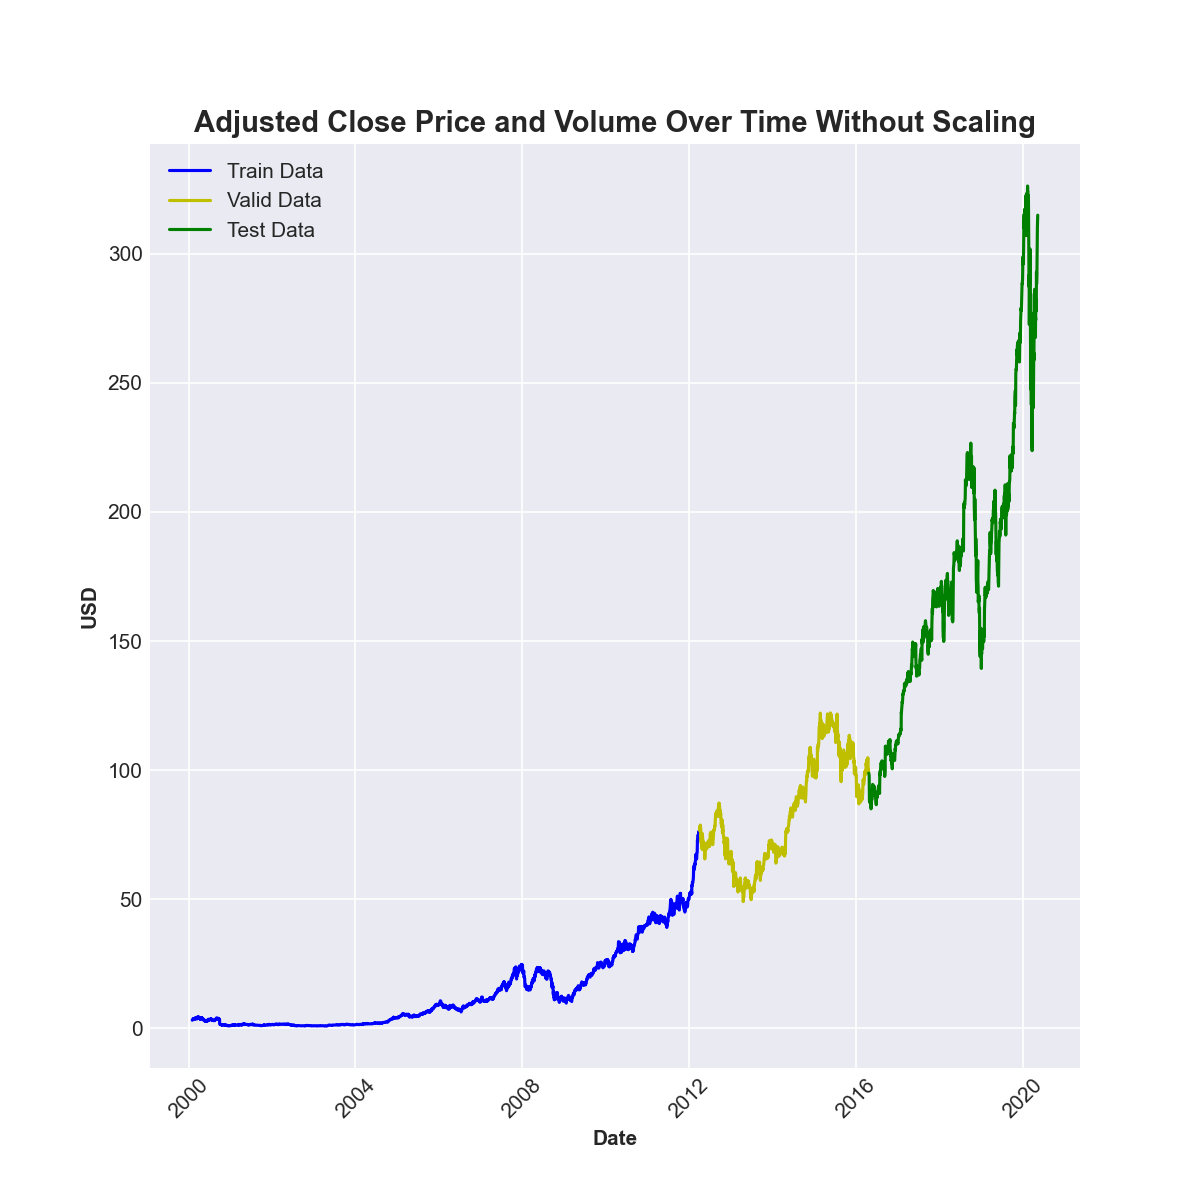

In [39]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.legend(['Train Data', 'Valid Data', 'Test Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xticks(rotation = 45)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show()

<IPython.core.display.Javascript object>


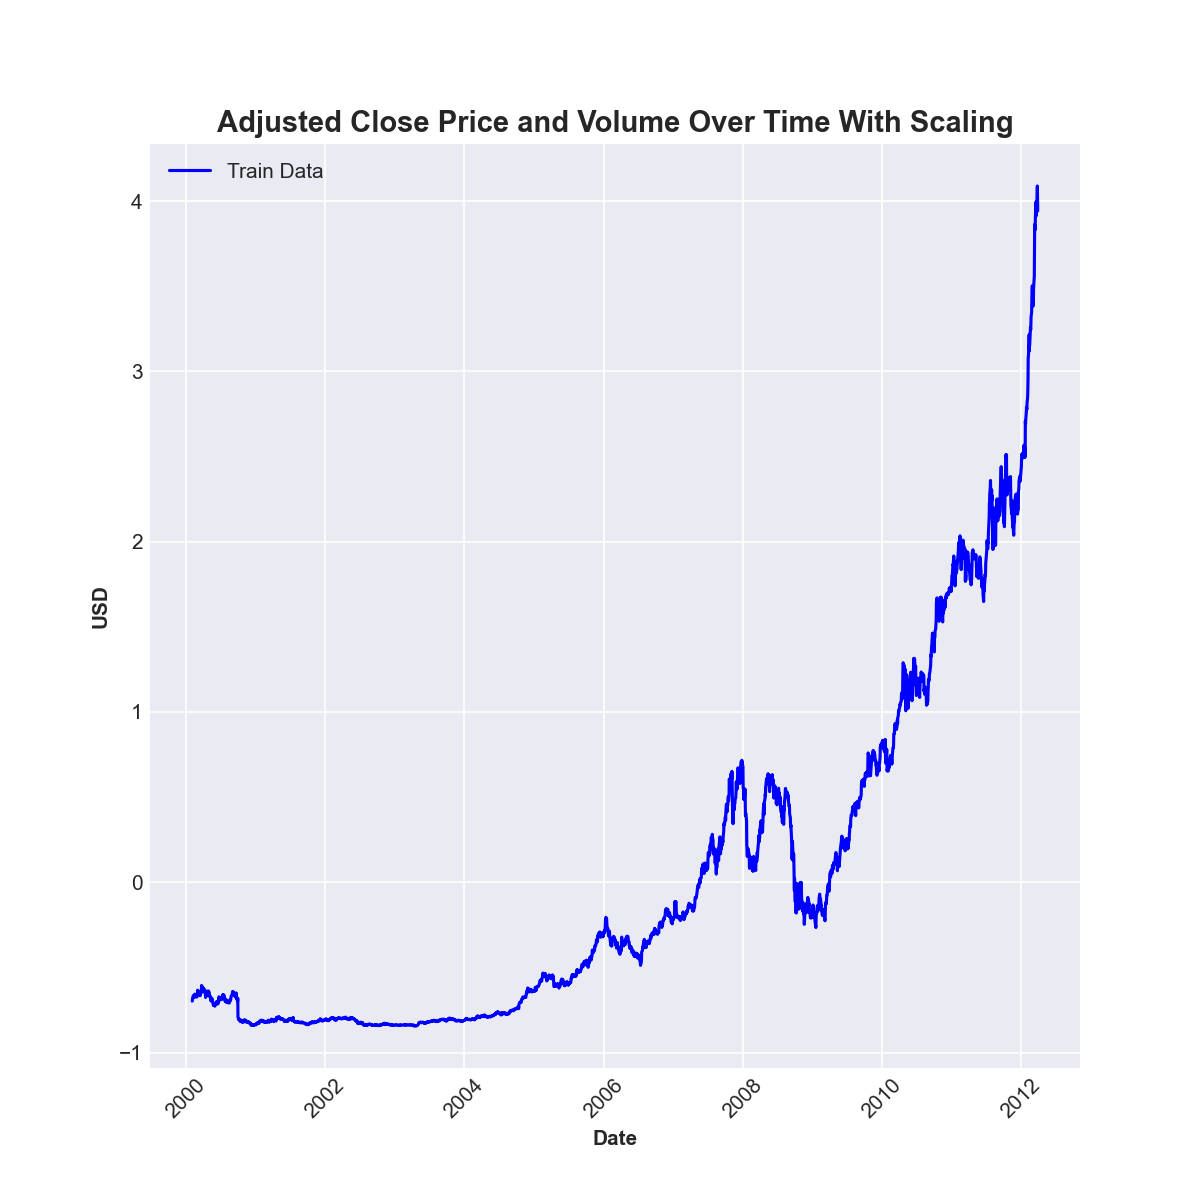

In [40]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train_df_scaled['DATE'], train_df_scaled['ADJ_CLOSE'], 'b-')
plt.legend(['Train Data'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time With Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [41]:
model = XGBRegressor(seed = model_seed,
                    n_estimators = n_estimators,
                    max_depth = max_depth,
                    learning_rate = learning_rate,
                    min_child_weight = min_child_weight,
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    colsample_bylevel = colsample_bylevel,
                    gamma = gamma)

model.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [42]:
predict_train_scaled = model.predict(X_train_scaled)
predict_train = predict_train_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

predit_train_df = pd.DataFrame({'PREDICT_VALUE':predict_train,
                               'DATE':train['DATE']})

print('MSE on Train Set =', mean_squared_error(y_train, predict_train))
print('MAE on Train Set =', mean_absolute_error(y_train, predict_train))

MSE on Train Set = 0.06507078692508744
MAE on Train Set = 0.16089457526705625


<IPython.core.display.Javascript object>


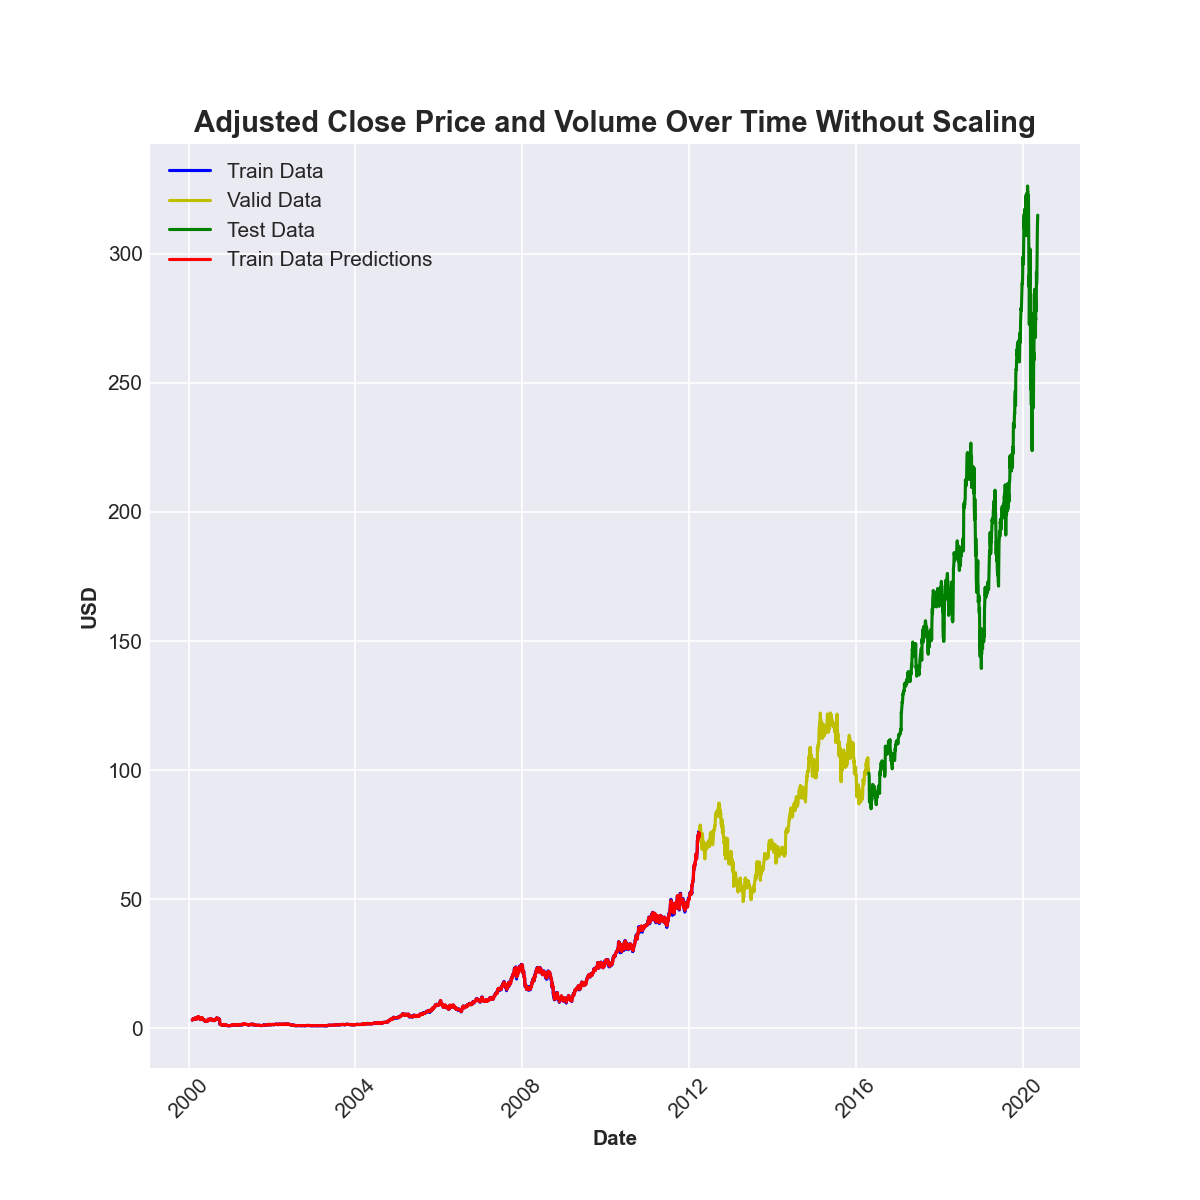

In [43]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_train_df['DATE'], predit_train_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Train Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show()

In [44]:
predict_valid_scaled = model.predict(X_valid_scaled)
valid['PREDICT_VALID'] = predict_valid_scaled
valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']

predit_valid_df = pd.DataFrame({'PREDICT_VALUE':valid['PREDICT'],
                               'DATE':valid['DATE']})

MSE_Original = mean_squared_error(y_valid, valid['PREDICT'])
MAE_Original = mean_absolute_error(y_valid, valid['PREDICT'])

print('MSE on Validation Set =', mean_squared_error(y_valid, valid['PREDICT']))
print('MAE on Validation Set =', mean_absolute_error(y_valid, valid['PREDICT']))

MSE on Validation Set = 2.2364627043805623
MAE on Validation Set = 1.0636583965694215


<ipython-input-44-ac8003239442>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT_VALID'] = predict_valid_scaled
<ipython-input-44-ac8003239442>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['PREDICT'] = valid['PREDICT_VALID'] * valid['ADJ_CLOSE_STD'] + valid['ADJ_CLOSE_MEAN']


<IPython.core.display.Javascript object>


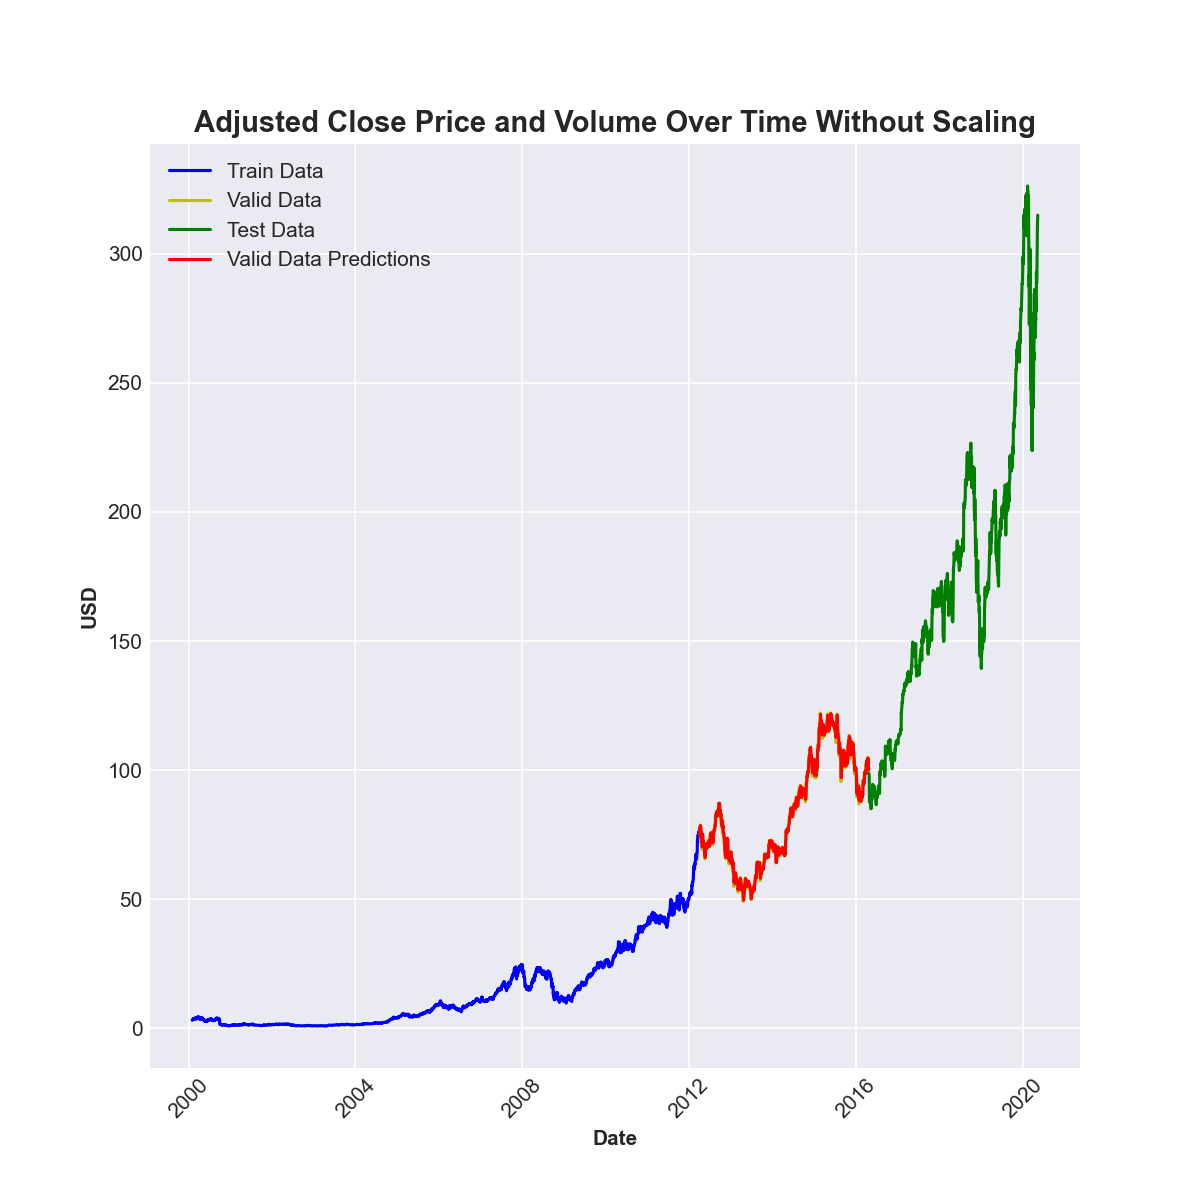

In [45]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_valid_df['DATE'], predit_valid_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Valid Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')
plt.xticks(rotation = 45)

mplcursors.cursor(hover = True)

plt.show();

In [46]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])
imp[-10:]

[('CLOSE_LAG_9', 0.019115577),
 ('OPEN_LAG_6', 0.024904827),
 ('CLOSE_LAG_10', 0.032033432),
 ('OPEN_LAG_9', 0.03567739),
 ('CLOSE_LAG_6', 0.04750903),
 ('OPEN_LAG_4', 0.054555684),
 ('OPEN_LAG_13', 0.06852484),
 ('OPEN_LAG_1', 0.10114896),
 ('CLOSE_LAG_1', 0.17949682),
 ('CLOSE_LAG_2', 0.38650098)]

In [47]:
imp = list(zip(train[features_list], model.feature_importances_))
imp.sort(key = lambda tup: tup[1])

imp_10 = imp[-10:]

category = []
value = []

for imp in imp_10:
    category.append(imp[0])
    value.append(imp[1])

imp_df = pd.DataFrame({'FEATURE':category,
                      'IMPORTANCE':value})

imp_df

,FEATURE,IMPORTANCE
0,CLOSE_LAG_9,0.019116
1,OPEN_LAG_6,0.024905
2,CLOSE_LAG_10,0.032033
3,OPEN_LAG_9,0.035677
4,CLOSE_LAG_6,0.047509
5,OPEN_LAG_4,0.054556
6,OPEN_LAG_13,0.068525
7,OPEN_LAG_1,0.101149
8,CLOSE_LAG_1,0.179497
9,CLOSE_LAG_2,0.386501


<IPython.core.display.Javascript object>


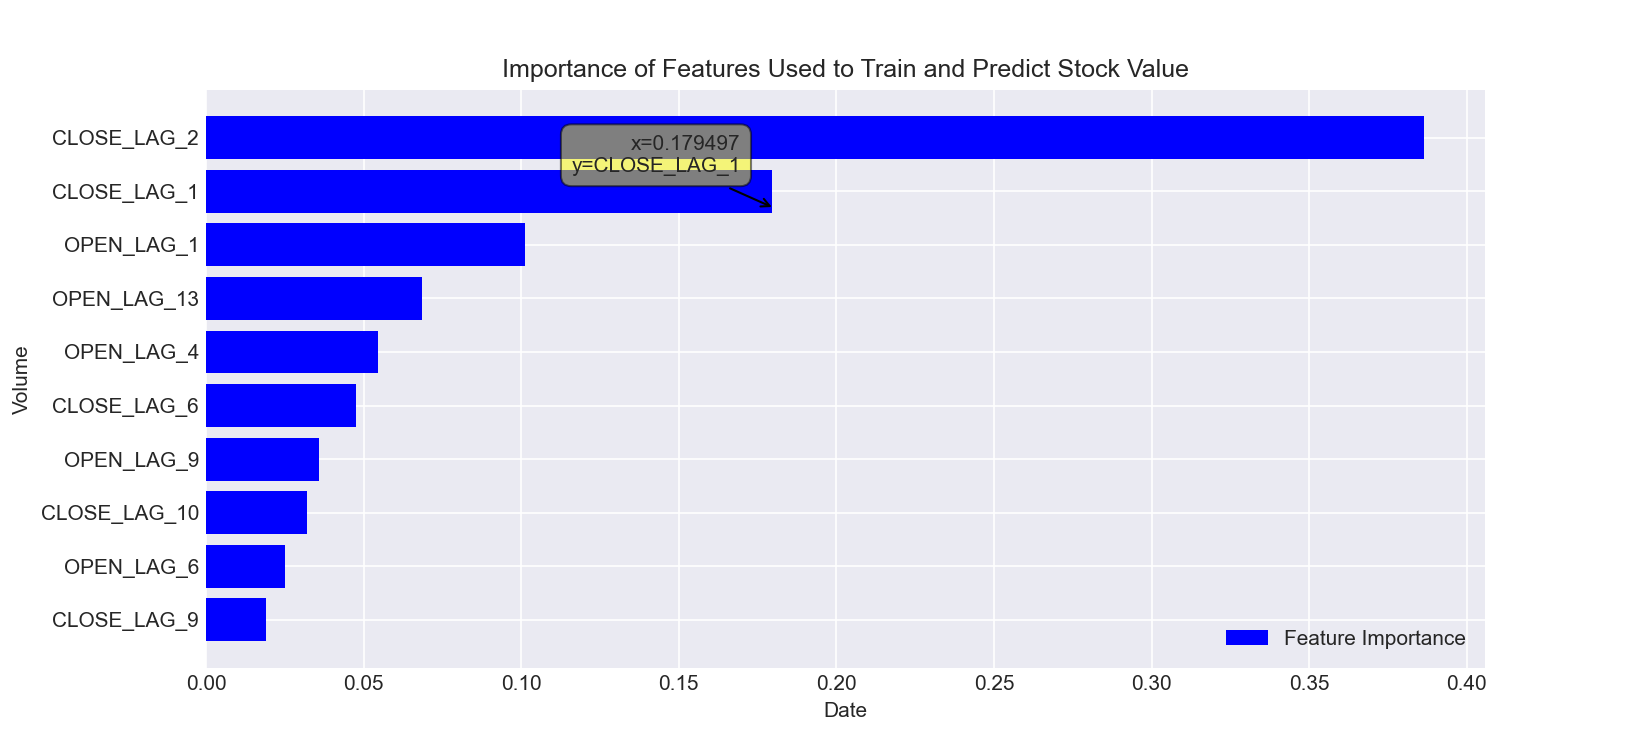

In [52]:
rcParams['figure.figsize'] = 11, 5

plt.figure()

plt.barh(imp_df['FEATURE'], imp_df['IMPORTANCE'], color = 'blue')
plt.legend(['Feature Importance'])
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title('Importance of Features Used to Train and Predict Stock Value')

mplcursors.cursor(hover = True)

plt.show()

In [53]:
n_estimators_parameter = 'n_estimators'
n_estimators_list = range(10, 500, 10)

max_depth_parameter = 'max_depth'
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rates = {n_estimators_parameter: [], max_depth_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(n_estimators_list):
    for param2 in max_depth_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = param,
                                                             max_depth = param2,
                                                             learning_rate = learning_rate,
                                                             min_child_weight = min_child_weight,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[n_estimators_parameter].append(param)
        error_rates[max_depth_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df1 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df1

<ipython-input-53-8cee86291e45>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(n_estimators_list):



Minutes Taken to Execute: 24.084219419956206


,n_estimators,max_depth,MSE,MAE
0,10,2,2.783456,1.206480
1,10,3,2.656539,1.175720
2,10,4,2.598066,1.165449
3,10,5,2.573562,1.155922
4,10,6,2.585221,1.162056
...,...,...,...,...
387,490,5,2.220727,1.061918
388,490,6,2.213216,1.059336
389,490,7,2.208128,1.059980
390,490,8,2.204905,1.057781


<IPython.core.display.Javascript object>


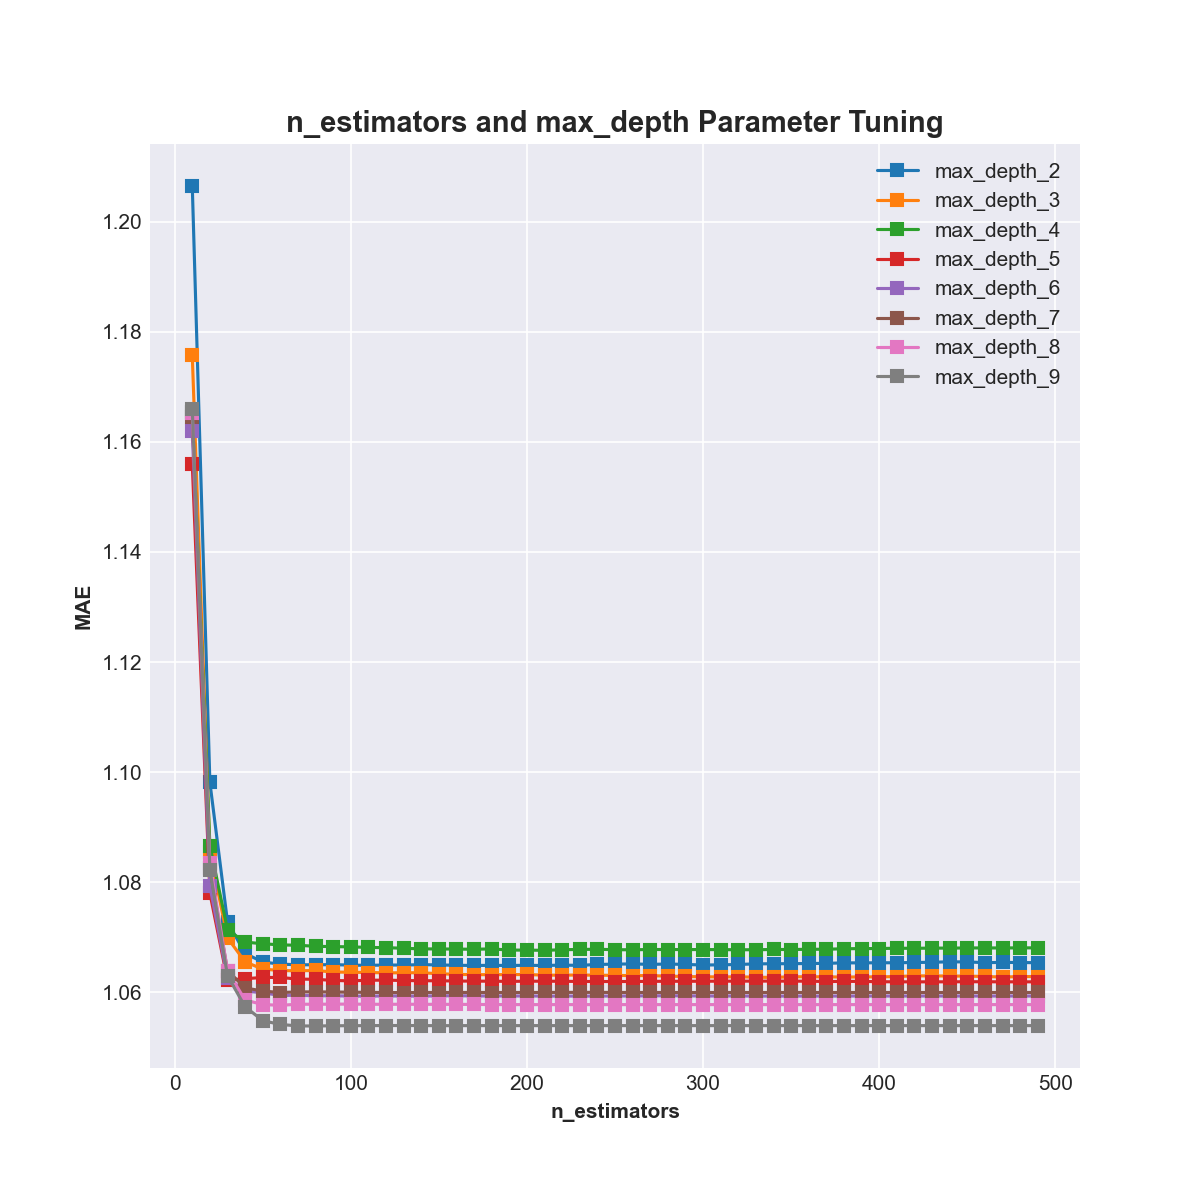

In [78]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(max_depth_list)):
    param = error_rate_df1[error_rate_df1[max_depth_parameter] == max_depth_list[p]]
    plt.plot(param[n_estimators_parameter], param['MAE'], marker = 's',)
    legend_list.append(max_depth_parameter + '_' + str(max_depth_list[p]))
    
plt.xlabel(n_estimators_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('n_estimators and max_depth Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [55]:
optimum = error_rate_df1[error_rate_df1['MSE'] == error_rate_df1['MSE'].min()]

print('Minimum MSE Value:', error_rate_df1['MSE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MSE Value: 2.1921618775632763
Optimum n_estimators Parameter: 80
Optimum max_depth Parameter: 9


In [56]:
optimum = error_rate_df1[error_rate_df1['MAE'] == error_rate_df1['MAE'].min()]

n_estimators_optimum = optimum['n_estimators'].values[0]
max_depth_optimum = optimum['max_depth'].values[0]

print('Minimum MAE Value:', error_rate_df1['MAE'].min())
print('Optimum n_estimators Parameter:', optimum['n_estimators'].values[0])
print('Optimum max_depth Parameter:', optimum['max_depth'].values[0])

Minimum MAE Value: 1.0538941423796555
Optimum n_estimators Parameter: 80
Optimum max_depth Parameter: 9


In [57]:
learning_rate_parameter = 'learning_rate'
learning_rate_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

min_child_weight_parameter = 'min_child_weight'
min_child_weight_list = range(5, 21, 1)

error_rates = {learning_rate_parameter: [], min_child_weight_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(learning_rate_list):
    for param2 in min_child_weight_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = param,
                                                             min_child_weight = param2,
                                                             subsample = subsample,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = gamma)
        error_rates[learning_rate_parameter].append(param)
        error_rates[min_child_weight_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df2 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df2

<ipython-input-57-5e425274f179>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(learning_rate_list):



Minutes Taken to Execute: 3.0972586989402773


,learning_rate,min_child_weight,MSE,MAE
0,0.001,5,4.197900,1.514699
1,0.001,6,4.197749,1.514670
2,0.001,7,4.197775,1.514686
3,0.001,8,4.197773,1.514686
4,0.001,9,4.197822,1.514693
...,...,...,...,...
107,0.300,16,2.207691,1.060191
108,0.300,17,2.213755,1.064448
109,0.300,18,2.213824,1.064877
110,0.300,19,2.230672,1.066807


<IPython.core.display.Javascript object>


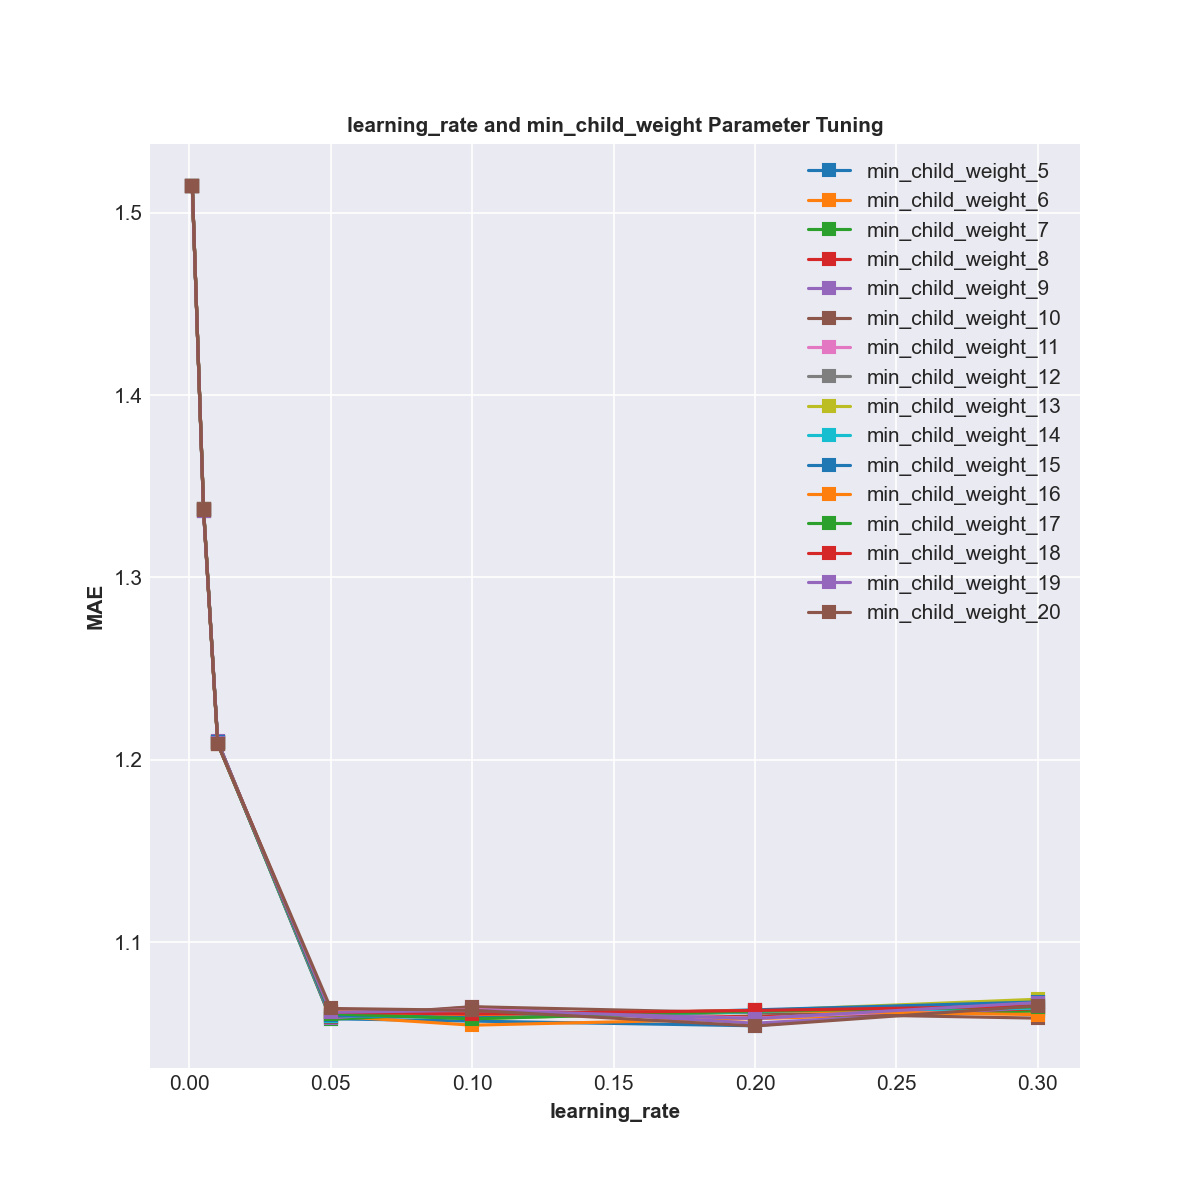

In [79]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(min_child_weight_list)):
    param = error_rate_df2[error_rate_df2[min_child_weight_parameter] == min_child_weight_list[p]]
    plt.plot(param[learning_rate_parameter], param['MAE'], marker = 's',)
    legend_list.append(min_child_weight_parameter + '_' + str(min_child_weight_list[p]))
    
plt.xlabel(learning_rate_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('learning_rate and min_child_weight Parameter Tuning', fontsize = 10, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [59]:
optimum = error_rate_df2[error_rate_df2['MSE'] == error_rate_df2['MSE'].min()]

print('Minimum MSE Value:', error_rate_df2['MSE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MSE Value: 2.191400311415084
Optimum learning_rate Parameter: 0.2
Optimum min_child_weight Parameter: 5


In [60]:
optimum = error_rate_df2[error_rate_df2['MAE'] == error_rate_df2['MAE'].min()]

learning_rate_optimum = optimum['learning_rate'].values[0]
min_child_weight_optimum = optimum['min_child_weight'].values[0]

print('Minimum MAE Value:', error_rate_df2['MAE'].min())
print('Optimum learning_rate Parameter:', optimum['learning_rate'].values[0])
print('Optimum min_child_weight Parameter:', optimum['min_child_weight'].values[0])

Minimum MAE Value: 1.0539515398154502
Optimum learning_rate Parameter: 0.2
Optimum min_child_weight Parameter: 20


In [61]:
subsample_parameter = 'subsample'
subsample_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

gamma_parameter = 'gamma'
gamma_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {subsample_parameter: [], gamma_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(subsample_list):
    for param2 in gamma_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = param,
                                                             colsample_bytree = colsample_bytree,
                                                             colsample_bylevel = colsample_bylevel,
                                                             gamma = param2)
        error_rates[subsample_parameter].append(param)
        error_rates[gamma_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df3 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df3

<ipython-input-61-000a039edf79>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(subsample_list):



Minutes Taken to Execute: 2.3684334834416707


,subsample,gamma,MSE,MAE
0,0.1,0.1,2.691141,1.188688
1,0.1,0.2,2.732431,1.204711
2,0.1,0.3,2.646856,1.166035
3,0.1,0.4,2.638746,1.164914
4,0.1,0.5,2.609530,1.161925
...,...,...,...,...
95,1.0,0.6,2.228934,1.064439
96,1.0,0.7,2.215523,1.059921
97,1.0,0.8,2.226933,1.066020
98,1.0,0.9,2.248815,1.072819


<IPython.core.display.Javascript object>


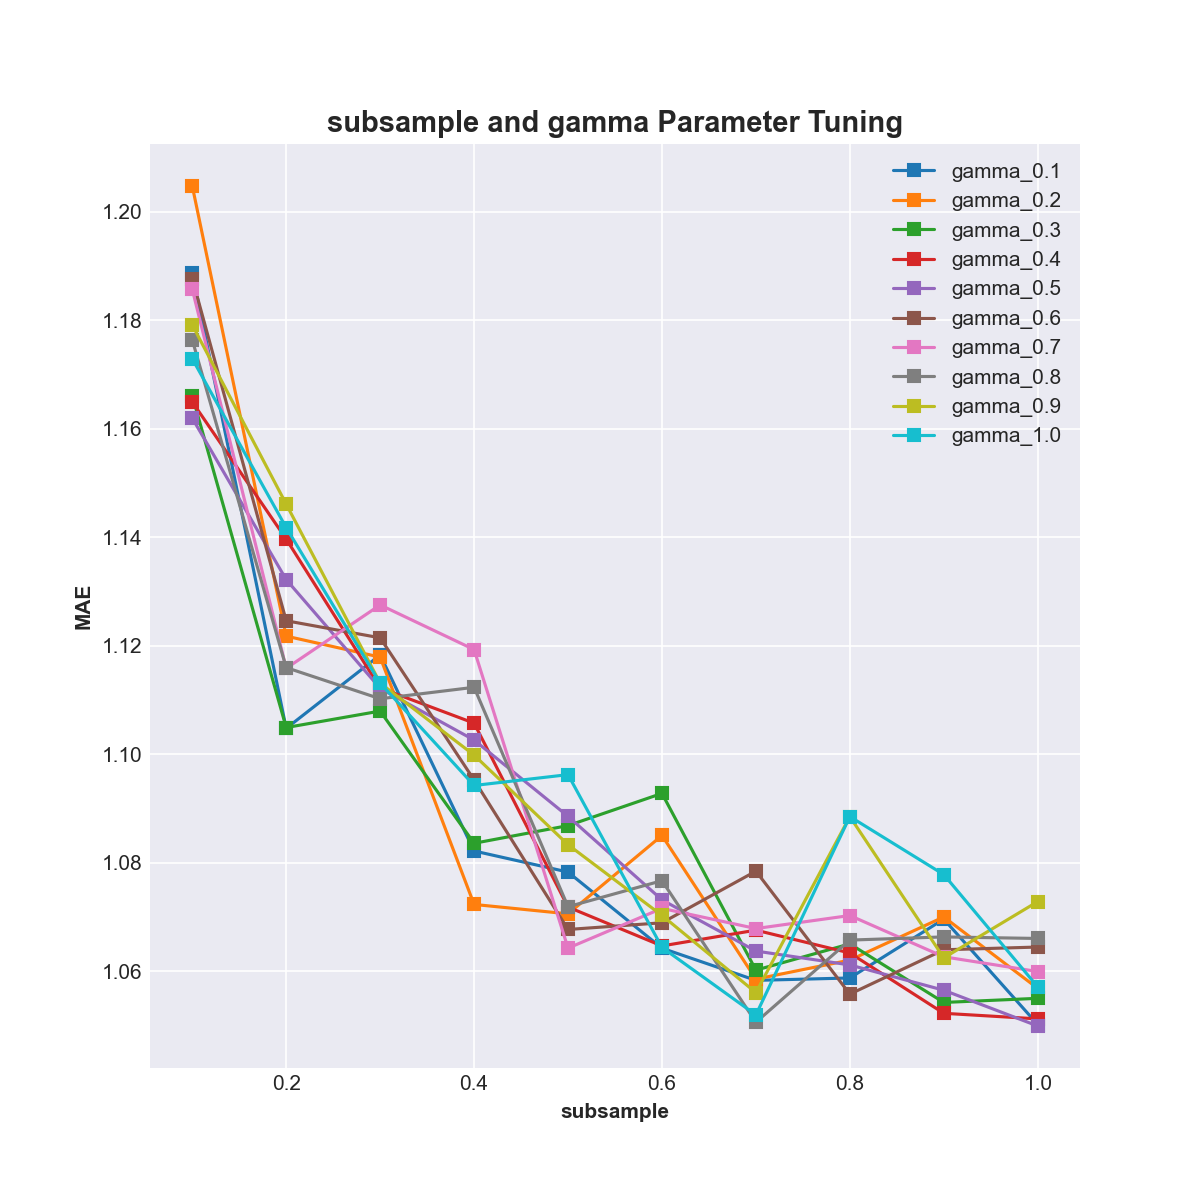

In [77]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(gamma_list)):
    param = error_rate_df3[error_rate_df3[gamma_parameter] == gamma_list[p]]
    plt.plot(param[subsample_parameter], param['MAE'], marker = 's',)
    legend_list.append(gamma_parameter + '_' + str(gamma_list[p]))
    
plt.xlabel(subsample_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('subsample and gamma Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [63]:
optimum = error_rate_df3[error_rate_df3['MSE'] == error_rate_df3['MSE'].min()]

print('Minimum MSE Value:', error_rate_df3['MSE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MSE Value: 2.172081551946423
Optimum subsample Parameter: 0.7
Optimum gamma Parameter: 0.8


In [64]:
optimum = error_rate_df3[error_rate_df3['MAE'] == error_rate_df3['MAE'].min()]

subsample_optimum = optimum['subsample'].values[0]
gamma_optimum = optimum['gamma'].values[0]

print('Minimum MAE Value:', error_rate_df3['MAE'].min())
print('Optimum subsample Parameter:', optimum['subsample'].values[0])
print('Optimum gamma Parameter:', optimum['gamma'].values[0])

Minimum MAE Value: 1.0498857457039923
Optimum subsample Parameter: 1.0
Optimum gamma Parameter: 0.5


In [65]:
colsample_bytree_parameter = 'colsample_bytree'
colsample_bytree_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

colsample_bylevel_parameter = 'colsample_bylevel'
colsample_bylevel_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

error_rates = {colsample_bytree_parameter: [], colsample_bylevel_parameter: [], 'MSE':[], 'MAE':[]}
start = time.time()

for param in tqdm_notebook(colsample_bytree_list):
    for param2 in colsample_bylevel_list:
        mse, mae, predicted_values = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             valid['ADJ_CLOSE_MEAN'],
                                                             valid['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = param,
                                                             colsample_bylevel = param2,
                                                             gamma = gamma_optimum)
        error_rates[colsample_bytree_parameter].append(param)
        error_rates[colsample_bylevel_parameter].append(param2)
        error_rates['MSE'].append(mse)
        error_rates['MAE'].append(mae)
        
error_rate_df4 = pd.DataFrame(error_rates)
end = time.time()
print('Minutes Taken to Execute: ' + str((end - start)/60.0))
error_rate_df4

<ipython-input-65-e3d8ff646ff8>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(colsample_bytree_list):



Minutes Taken to Execute: 0.8903257052103678


,colsample_bytree,colsample_bylevel,MSE,MAE
0,0.5,0.5,3.398541,1.370732
1,0.5,0.6,3.162061,1.316969
2,0.5,0.7,3.056153,1.282407
3,0.5,0.8,3.028437,1.279916
4,0.5,0.9,2.855898,1.220341
5,0.5,1.0,2.665226,1.178539
6,0.6,0.5,3.174368,1.291404
7,0.6,0.6,3.036560,1.266044
8,0.6,0.7,2.786199,1.205965
9,0.6,0.8,2.579191,1.152759


<IPython.core.display.Javascript object>


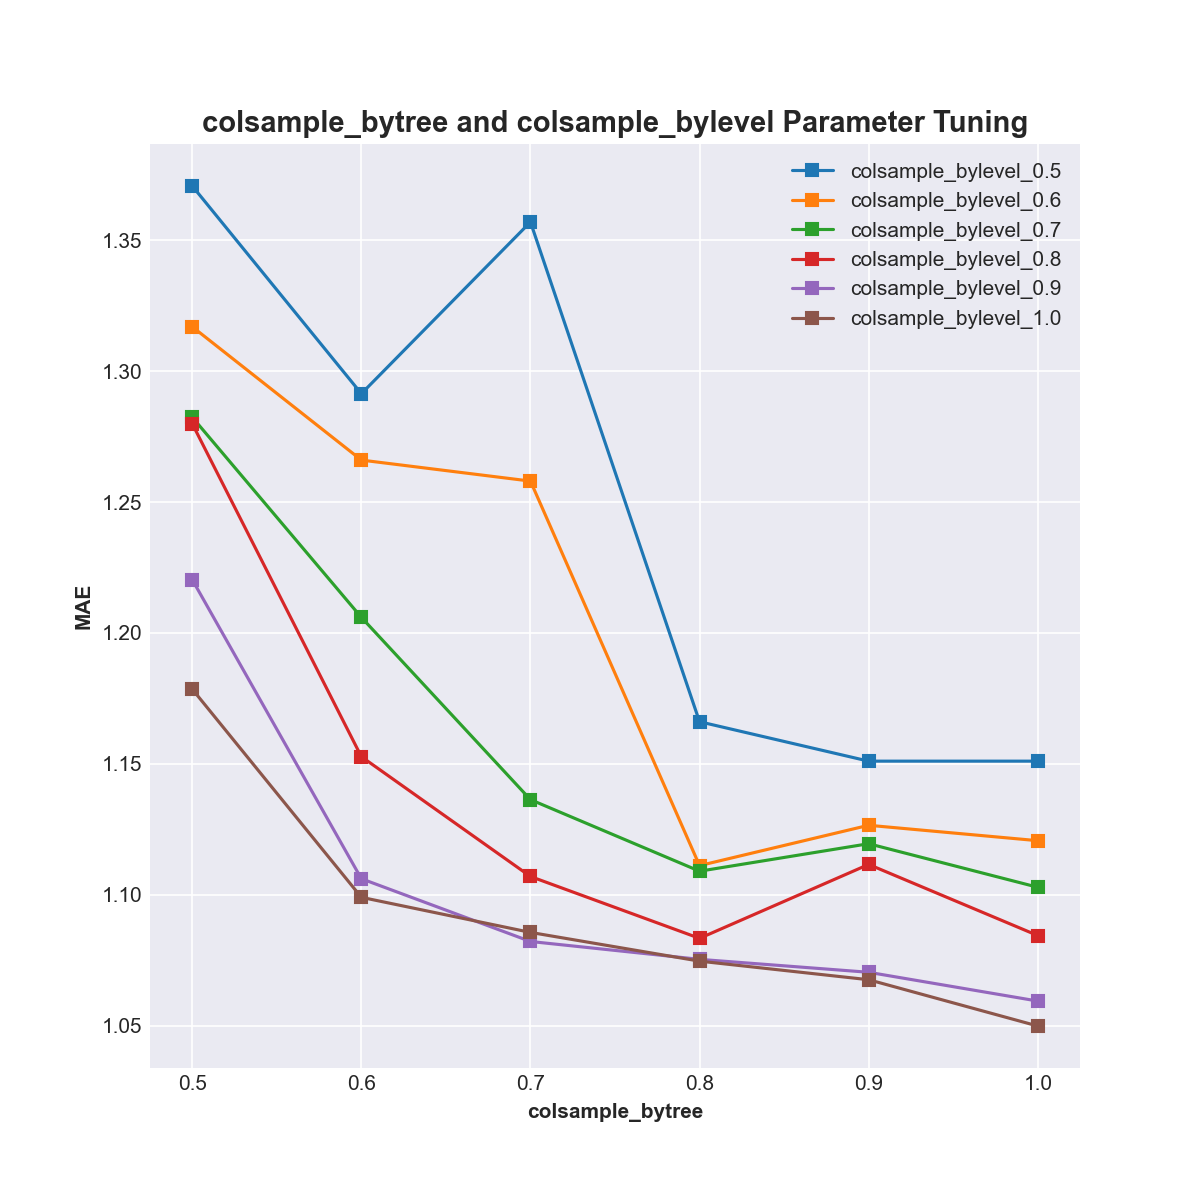

In [66]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

legend_list = []

for p in range(len(colsample_bylevel_list)):
    param = error_rate_df4[error_rate_df4[colsample_bylevel_parameter] == colsample_bylevel_list[p]]
    plt.plot(param[colsample_bytree_parameter], param['MAE'], marker = 's',)
    legend_list.append(colsample_bylevel_parameter + '_' + str(colsample_bylevel_list[p]))
    
plt.xlabel(colsample_bytree_parameter, fontweight = 'bold')
plt.ylabel('MAE', fontweight = 'bold')
plt.title('colsample_bytree and colsample_bylevel Parameter Tuning', fontsize = 14, fontweight = 'bold')
plt.legend(legend_list, loc = 'upper right')

mplcursors.cursor(hover = True)

plt.show();

In [67]:
optimum = error_rate_df4[error_rate_df4['MSE'] == error_rate_df4['MSE'].min()]

MSE_Optimum = error_rate_df4['MSE'].min()

print('Minimum MSE Value:', error_rate_df4['MSE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MSE Value: 2.1852202670578262
Optimum colsample_bytree Parameter: 1.0
Optimum colsample_bylevel Parameter: 1.0


In [68]:
optimum = error_rate_df4[error_rate_df4['MAE'] == error_rate_df4['MAE'].min()]

MAE_Optimum = error_rate_df4['MAE'].min()

colsample_bytree_optimum = optimum['colsample_bytree'].values[0]
colsample_bylevel_optimum = optimum['colsample_bylevel'].values[0]

print('Minimum MAE Value:', error_rate_df4['MAE'].min())
print('Optimum colsample_bytree Parameter:', optimum['colsample_bytree'].values[0])
print('Optimum colsample_bylevel Parameter:', optimum['colsample_bylevel'].values[0])

Minimum MAE Value: 1.0498857457039923
Optimum colsample_bytree Parameter: 1.0
Optimum colsample_bylevel Parameter: 1.0


In [69]:
tuned_params_df = pd.DataFrame({'PARAMETER':['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma'],
                               'ORIGINAL':[n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma],
                               'OPTIMUM':[n_estimators_optimum, max_depth_optimum, learning_rate_optimum, min_child_weight_optimum, subsample_optimum, colsample_bytree_optimum, colsample_bylevel_optimum, gamma_optimum]})

MSE_values_df = pd.DataFrame({'PARAMETER':['MSE'],
                                    'ORIGINAL':[MSE_Original],
                                    'OPTIMUM':[MSE_Optimum]})

MAE_values_df = pd.DataFrame({'PARAMETER':['MAE'],
                                    'ORIGINAL':[MAE_Original],
                                    'OPTIMUM':[MAE_Optimum]})

tuned_params_df

,PARAMETER,ORIGINAL,OPTIMUM
0,n_estimators,100.0,80.0
1,max_depth,3.0,9.0
2,learning_rate,0.1,0.2
3,min_child_weight,1.0,20.0
4,subsample,1.0,1.0
5,colsample_bytree,1.0,1.0
6,colsample_bylevel,1.0,1.0
7,gamma,0.0,0.5


In [70]:
MSE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MSE,2.236463,2.18522


In [71]:
MAE_values_df

,PARAMETER,ORIGINAL,OPTIMUM
0,MAE,1.063658,1.049886


<IPython.core.display.Javascript object>


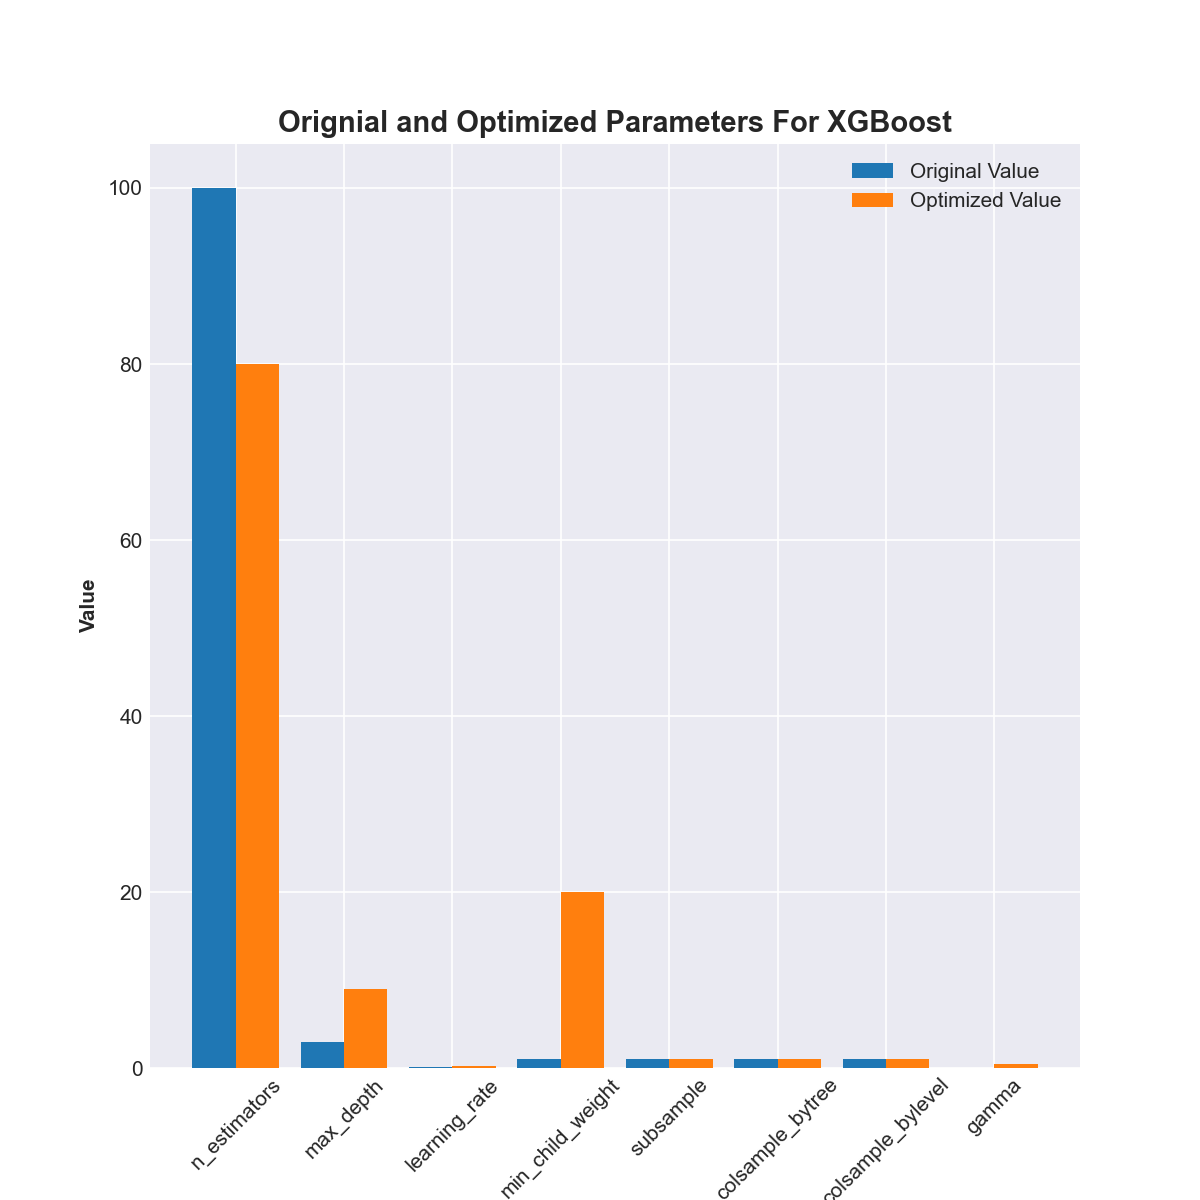

In [72]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_parameters = [tuned_params_df['ORIGINAL'], tuned_params_df['OPTIMUM']]
X_parameters = tuned_params_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_parameters)
_X = np.arange(len(X_parameters))
for i in range(len(vals_parameters)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_parameters[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_parameters, rotation=45)
plt.title('Orignial and Optimized Parameters For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Parameters', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


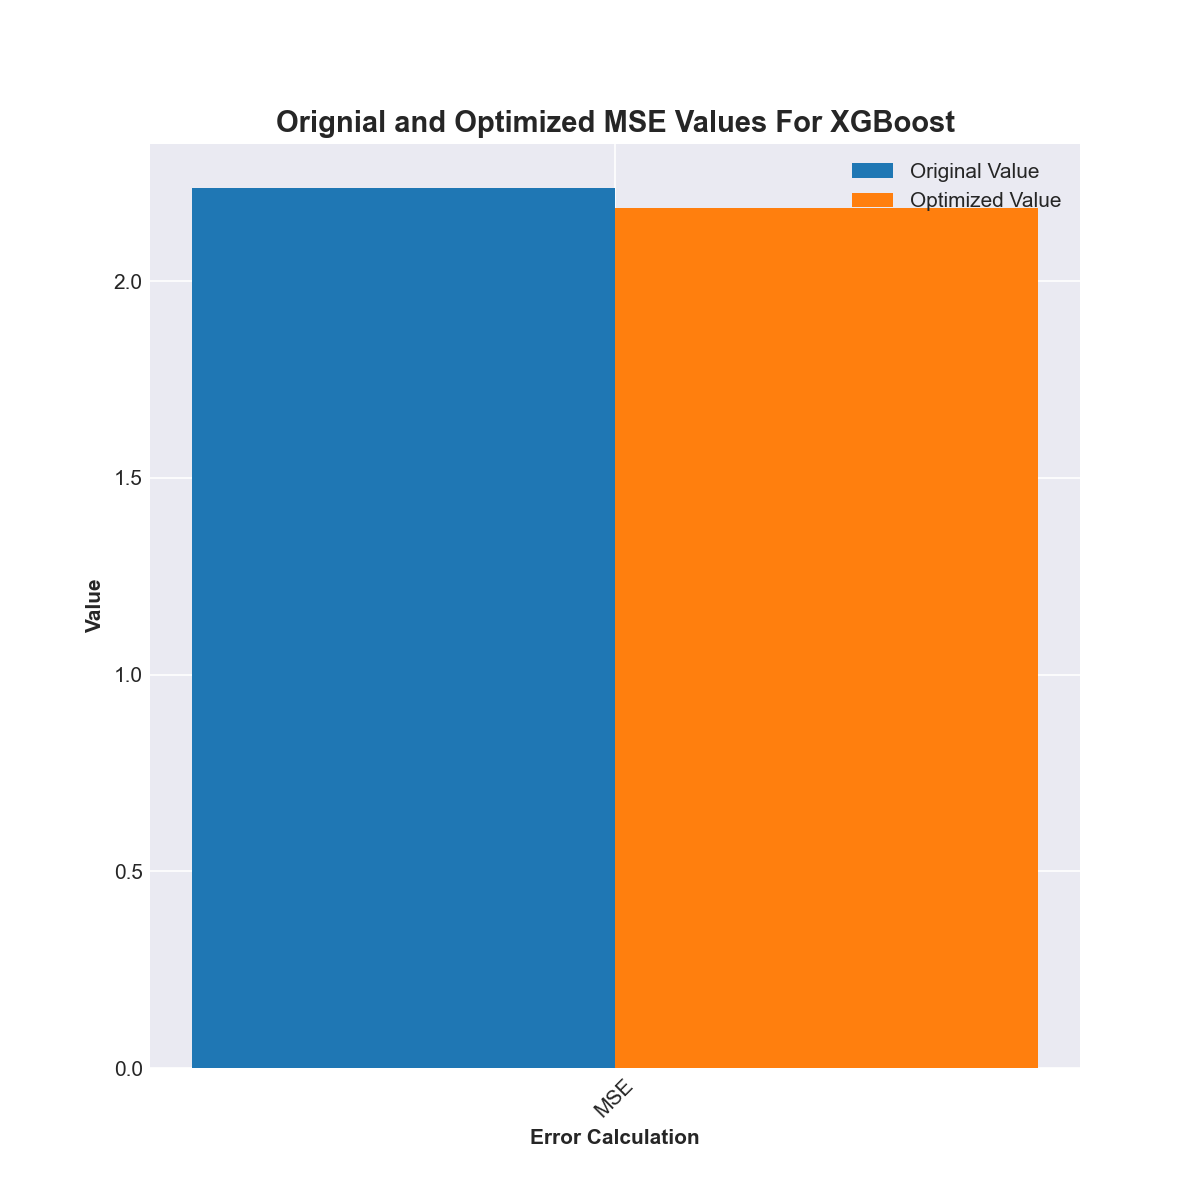

In [73]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MSE = [MSE_values_df['ORIGINAL'], MSE_values_df['OPTIMUM']]
X_MSE = MSE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MSE)
_X = np.arange(len(X_MSE))
for i in range(len(vals_MSE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MSE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MSE, rotation=45)
plt.title('Orignial and Optimized MSE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

<IPython.core.display.Javascript object>


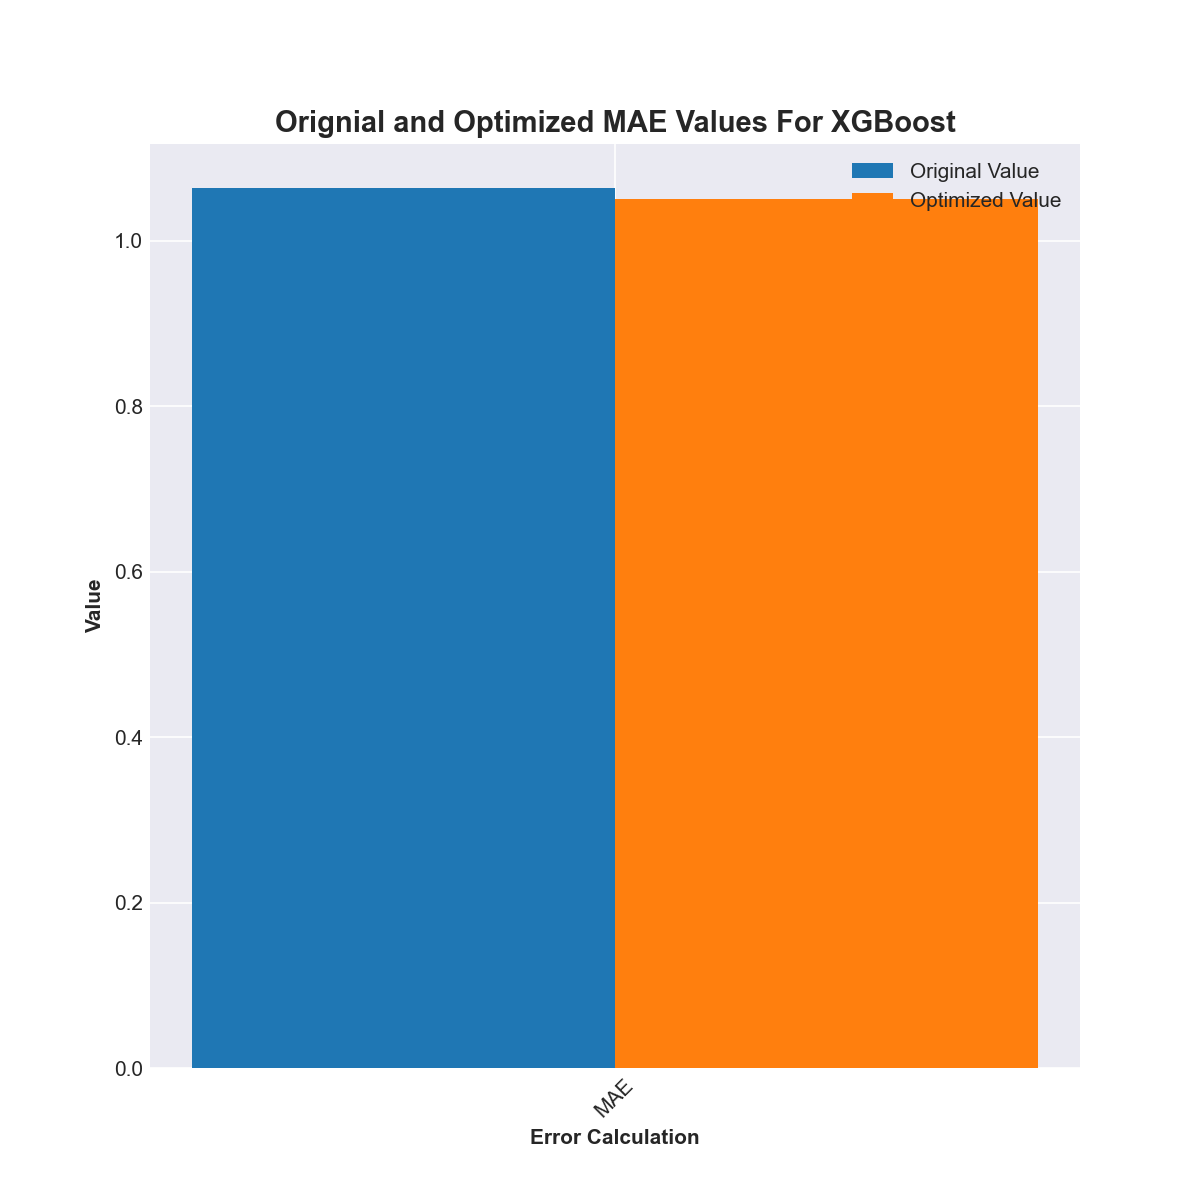

In [74]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

vals_MAE = [MAE_values_df['ORIGINAL'], MAE_values_df['OPTIMUM']]
X_MAE = MAE_values_df['PARAMETER']
legend_list = ['Original Value', 'Optimized Value']
n = len(vals_MAE)
_X = np.arange(len(X_MAE))
for i in range(len(vals_MAE)):
    plt.bar(_X - 0.8/2. + i/float(n)*0.8, vals_MAE[i], width = 0.8/float(n), align = 'edge')
plt.xticks(_X, X_MAE, rotation=45)
plt.title('Orignial and Optimized MAE Values For XGBoost', fontsize = 14, fontweight = 'bold')
plt.ylabel('Value', fontweight = 'bold')
plt.xlabel('Error Calculation', fontweight = 'bold')
plt.legend(legend_list)

cursor = mplcursors.cursor(hover=True)
@cursor.connect("add")
def on_add(sel):
    x, y, width, height = sel.artist[sel.target.index].get_bbox().bounds
    sel.annotation.set(text=f"{height}", position=(0, 20))
    sel.annotation.xy = (x + width / 2, y + height)

plt.show();

In [75]:
mse, mae, predicted_test = cf.train_pred_eval_model(X_train_scaled,
                                                             y_train_scaled,
                                                             X_valid_scaled,
                                                             y_valid,
                                                             test['ADJ_CLOSE_MEAN'],
                                                             test['ADJ_CLOSE_STD'],
                                                             seed = model_seed,
                                                             n_estimators = n_estimators_optimum,
                                                             max_depth = max_depth_optimum,
                                                             learning_rate = learning_rate_optimum,
                                                             min_child_weight = min_child_weight_optimum,
                                                             subsample = subsample_optimum,
                                                             colsample_bytree = colsample_bytree_optimum,
                                                             colsample_bylevel = colsample_bylevel_optimum,
                                                             gamma = gamma_optimum)


predit_test_df = pd.DataFrame({'PREDICT_VALUE':predicted_test,
                               'DATE':test['DATE']})

print('MSE Value:', mse)
print('MAE Value:', mae)

MSE Value: 10461.692189826514
MAE Value: 90.74018721942205


<IPython.core.display.Javascript object>


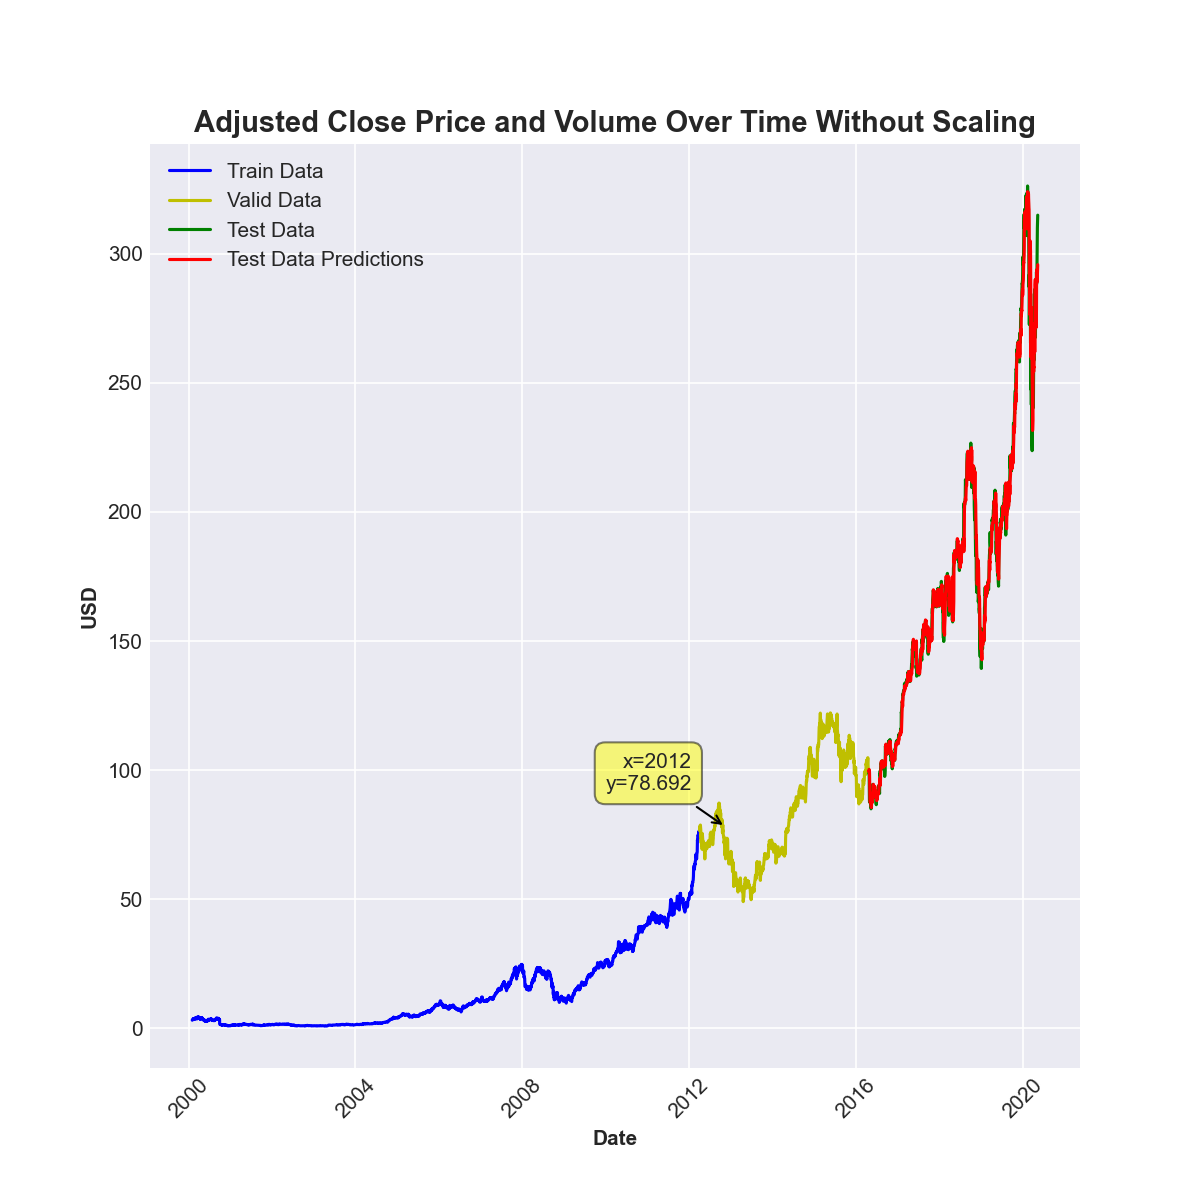

In [76]:
rcParams['figure.figsize'] = 8, 8

plt.figure()

plt.plot(train['DATE'], train['ADJ_CLOSE'], 'b-')
plt.plot(valid['DATE'], valid['ADJ_CLOSE'], 'y-')
plt.plot(test['DATE'], test['ADJ_CLOSE'], 'g-')
plt.plot(predit_test_df['DATE'], predit_test_df['PREDICT_VALUE'], 'r-')
plt.legend(['Train Data', 'Valid Data', 'Test Data', 'Test Data Predictions'])
plt.ylabel('USD', fontweight = 'bold')
plt.title('Adjusted Close Price and Volume Over Time Without Scaling', fontsize = 14, fontweight = 'bold')
plt.xticks(rotation = 45)
plt.grid(True)

plt.xlabel('Date', fontweight = 'bold')

mplcursors.cursor(hover = True)

plt.show();